In [4]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
from scipy import stats
import pandas as pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import nnls
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import entropy



In [106]:
# Load individual param op with common seed
parameters_all = pandas.read_csv('seed vs. param op/Optimized param - version 9 L2 division.csv')
# FINAL: Optimized param - version 9 L2 division.csv

# Load individual seed op
seeding_all = pandas.read_csv('seed vs. param op/Optimized seed - version 9 - divided by sqr(L2), lambda = 0.04 2.csv')
# FINAL: L2 division in individual cost function too: 'Optimized seed - version 9 - divided by sqr(L2), lambda = 0.04 2.csv 

# Load individual param op with canonical seeds
params_entorhinal_seed = pandas.read_csv('seed vs. param op/Optimized param - canonical entorhinal.csv')
params_middletemporal_seed = pandas.read_csv('seed vs. param op/Optimized param - canonical middletemporal.csv')
params_fusiform_seed = pandas.read_csv('seed vs. param op/Optimized param - canonical fusiform.csv')
params_inferiortemporal_seed = pandas.read_csv('seed vs. param op/Optimized param - canonical inferiortemporal.csv')

# Load empirical tau data
ebm_data = pandas.read_csv('EBM stage + tau/Stage + tau - version 9 final run.csv')
# FINAL: 'Cross-sectional stage and regional tau - version 9.csv'


## Post Processing

In [107]:
# Keep only MCI and AD subjects for analysis
ebm_nonzero = ebm_data[ebm_data['Diagnosis'] != 'CN']
seeding_nonzero = seeding_all[seeding_all['Diagnosis'] != 'CN']
parameters_nonzero = parameters_all[parameters_all['Diagnosis'] != 'CN']
params_entorhinal_seed_nonzero = params_entorhinal_seed[params_entorhinal_seed['Diagnosis'] != 'CN']
params_middletemporal_seed_nonzero = params_middletemporal_seed[params_middletemporal_seed['Diagnosis'] != 'CN']
params_fusiform_seed_nonzero = params_fusiform_seed[params_fusiform_seed['Diagnosis'] != 'CN']
params_inferiortemporal_seed_nonzero = params_inferiortemporal_seed[params_inferiortemporal_seed['Diagnosis'] != 'CN']

#Delete stage 0 subjects
ebm_nonzero = ebm_nonzero[ebm_nonzero['ml_stage'] != 0]
seeding_nonzero = seeding_nonzero[seeding_nonzero['ml_stage'] != 0]
parameters_nonzero = parameters_nonzero[parameters_nonzero['ml_stage'] != 0]
params_entorhinal_seed_nonzero = params_entorhinal_seed_nonzero[params_entorhinal_seed_nonzero['ml_stage'] != 0]
params_middletemporal_seed_nonzero = params_middletemporal_seed_nonzero[params_middletemporal_seed_nonzero['ml_stage'] != 0]
params_fusiform_seed_nonzero = params_fusiform_seed_nonzero[params_fusiform_seed_nonzero['ml_stage'] != 0]
params_inferiortemporal_seed_nonzero = params_inferiortemporal_seed_nonzero[params_inferiortemporal_seed_nonzero['ml_stage'] != 0]

# Delete striatal regions in ebm data
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']
ebm_nonzero = ebm_nonzero.drop(columns=regions_to_exclude)
ebm_data = ebm_data.drop(columns=regions_to_exclude)

# Print value count for diagnostic categories
parameters_nonzero.Diagnosis.value_counts()


Diagnosis
MCI         104
Dementia     61
Name: count, dtype: int64

In [35]:
# Sort by diagnosis 
CN_param = parameters_nonzero[parameters_nonzero['Diagnosis'] == 'CN']
MCI_param = parameters_nonzero[parameters_nonzero['Diagnosis'] == 'MCI']
AD_param = parameters_nonzero[parameters_nonzero['Diagnosis'] == 'Dementia']
CN_by_stage_param = CN_param.sort_values(by='ml_stage')
MCI_by_stage_param = MCI_param.sort_values(by='ml_stage')
AD_by_stage_param = AD_param.sort_values(by='ml_stage')
parameters_by_diagnosis = pandas.concat([CN_by_stage_param, MCI_by_stage_param, AD_by_stage_param], ignore_index=True)

CN_seed = seeding_nonzero[seeding_nonzero['Diagnosis'] == 'CN']
MCI_seed = seeding_nonzero[seeding_nonzero['Diagnosis'] == 'MCI']
AD_seed = seeding_nonzero[seeding_nonzero['Diagnosis'] == 'Dementia']
CN_by_stage_seed = CN_seed.sort_values(by='ml_stage')
MCI_by_stage_seed = MCI_seed.sort_values(by='ml_stage')
AD_by_stage_seed = AD_seed.sort_values(by='ml_stage')
seeding_by_diagnosis = pandas.concat([MCI_by_stage_seed, AD_by_stage_seed], ignore_index=True)

CN_ebm = ebm_nonzero[ebm_nonzero['Diagnosis'] == 'CN']
MCI_ebm = ebm_nonzero[ebm_nonzero['Diagnosis'] =='MCI']
AD_ebm = ebm_nonzero[ebm_nonzero['Diagnosis'] == 'Dementia']
CN_by_stage_ebm = CN_ebm.sort_values(by='ml_stage')
MCI_by_stage_ebm = MCI_ebm.sort_values(by='ml_stage')
AD_by_stage_ebm = AD_ebm.sort_values(by='ml_stage')
ebm_by_diagnosis = pandas.concat([CN_by_stage_ebm, MCI_by_stage_ebm, AD_by_stage_ebm], ignore_index=True)

# Calculate column means (overall and for each diagnositic category)
means_param = parameters_by_diagnosis.mean(numeric_only=True).to_frame().T
means_param_CN = CN_param.mean(numeric_only=True).to_frame().T
means_param_MCI = MCI_param.mean(numeric_only=True).to_frame().T
means_param_AD = AD_param.mean(numeric_only=True).to_frame().T
means_seed = seeding_by_diagnosis.mean(numeric_only=True).to_frame().T
means_seed_CN = CN_seed.mean(numeric_only=True).to_frame().T
means_seed_MCI = MCI_seed.mean(numeric_only=True).to_frame().T
means_seed_AD = AD_seed.mean(numeric_only=True).to_frame().T

# Parameter Optimization

   Unnamed: 0          RID  ml_stage       MSE         R     alpha      beta  \
0  325.812121  4836.266667  6.060606  0.699572  0.149647  0.275248  0.913942   

   gamma    s    b    p     k  
0    1.0  0.5  0.0  0.0  50.0  


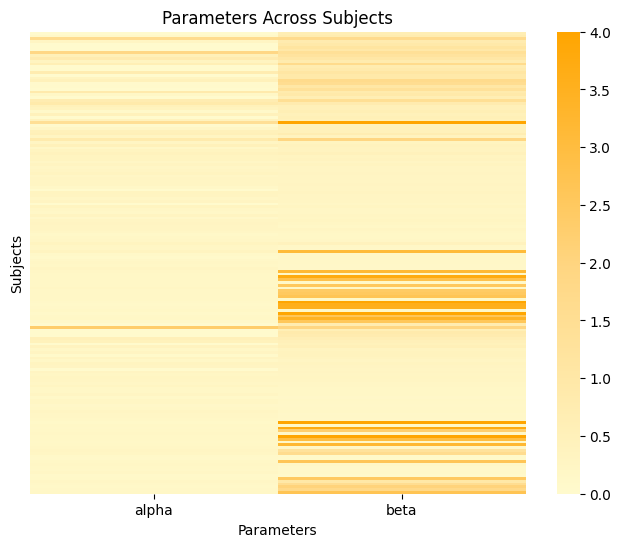

In [36]:
# Plot heat map of parameter values across subjects
yellow_palette = LinearSegmentedColormap.from_list("pale_yellow_to_orange", ["#FFFACD", "#FFD580", "#FFA500"])

plt.figure(figsize=(8, 6)) 
sns.heatmap(parameters_by_diagnosis.iloc[:,6:8], cmap=yellow_palette, yticklabels=False, vmin=0, vmax=4) 
plt.xlabel('Parameters')
plt.ylabel('Subjects')
plt.title('Parameters Across Subjects')

# Print average parameter values
print(means_param)

Text(0.5, 1.0, 'Alpha Histogram for Parameter Optimization')

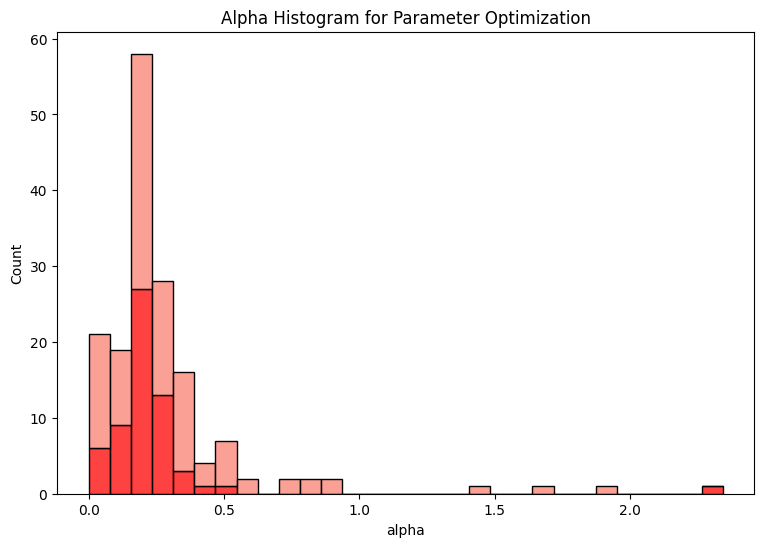

In [37]:
# Alpha histogram
color_palette = {
    'Dementia': '#FE0101',  # Deep red
    'MCI': '#FA8072',  # Salmon
    'CN': '#F5F5DC'}   # Beige (light beige)

plt.figure(figsize=(9, 6))
ax = sns.histplot(data=parameters_nonzero, bins = 30, x='alpha', color = 'red', palette = color_palette, hue='Diagnosis', multiple='stack', legend=False)
plt.title('Alpha Histogram for Parameter Optimization')
#plt.legend(title='Diagnosis')
#plt.xlim(-0.1, 1.8)
#plt.ylim(0, 450)


Text(0.5, 1.0, 'Beta Histogram for Parameter Optimization')

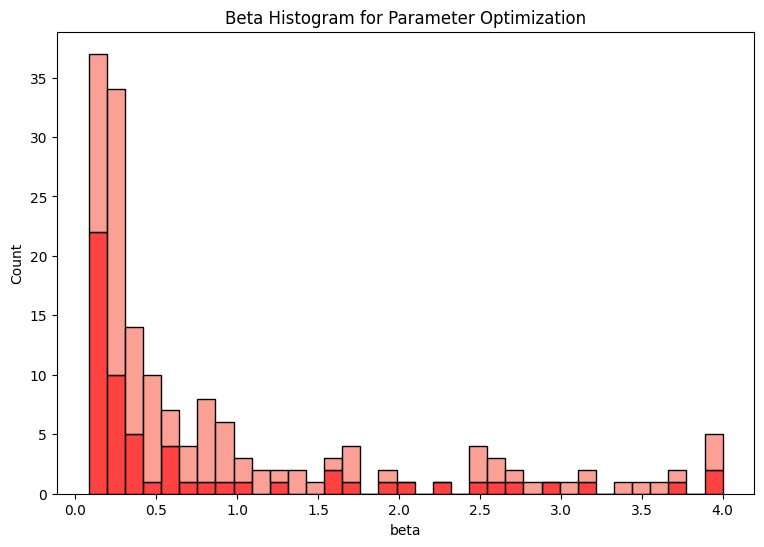

In [38]:
# Beta histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=parameters_nonzero, bins = 35, x='beta', color = 'red',hue='Diagnosis', palette= color_palette, multiple='stack', legend=False)
plt.title('Beta Histogram for Parameter Optimization')
#plt.xlim(0, 3)
#plt.ylim(0, 450)

(0.0, 165.0)

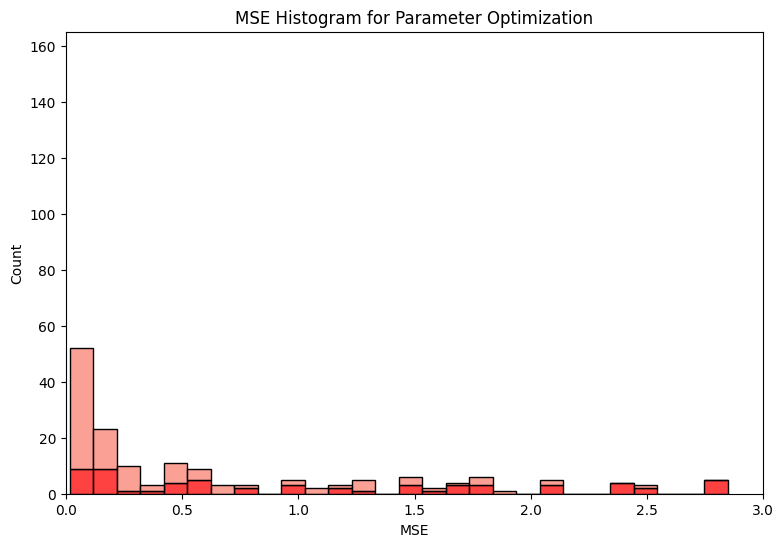

In [451]:
# Create histogram of MSE 
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=parameters_nonzero, binwidth= 0.1, x='MSE', color = 'red', hue='Diagnosis', palette=color_palette, multiple='stack',legend=False)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.title('MSE Histogram for Parameter Optimization')
plt.xlim(0, 3)
plt.ylim(0, 165)

(0.0, 55.0)

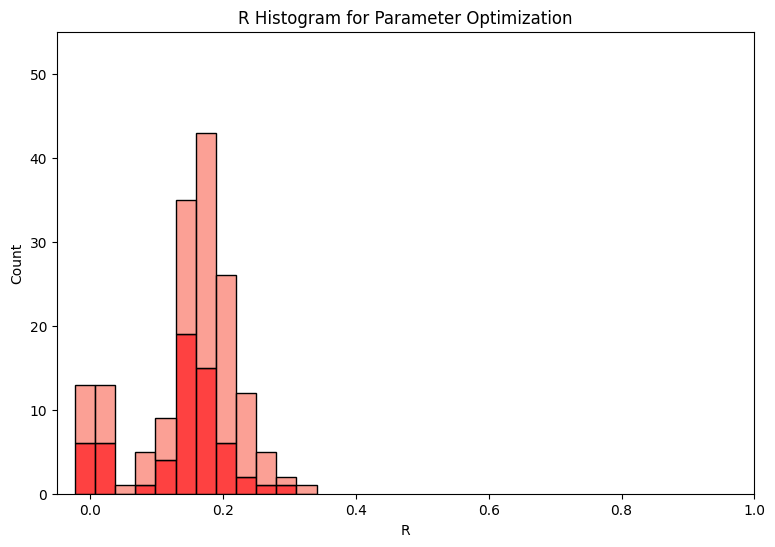

In [452]:
# Histogram for R
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=parameters_nonzero, binwidth= 0.03, x='R', color = 'red', hue='Diagnosis', palette=color_palette, multiple='stack',legend=False)
plt.xlabel('R')
plt.ylabel('Count')
plt.title('R Histogram for Parameter Optimization')
plt.xlim(-.05, 1)
plt.ylim(0, 55)

# Seed Optimization

In [453]:
# Calculating entropy across subjects for each region 
entropy_dict = {}

for region in seeding_by_diagnosis.columns[6:]: 
    tau_seed_values = seeding_by_diagnosis[region].values
    
    # Normalize the data 
    probability_distribution = tau_seed_values / tau_seed_values.sum()
    
    # Calculate the entropy for the region
    entropy_value = entropy(probability_distribution)
    entropy_dict[region] = entropy_value

entropy_df = pandas.DataFrame(list(entropy_dict.items()), columns=['Region', 'Entropy'])
mean_entropy = entropy_df['Entropy'].mean()
print('Mean entropy across regions: ' + str(mean_entropy))
sorted_entropy_df = entropy_df.sort_values(by='Entropy', ascending=False)
top_5_regions = sorted_entropy_df.head(5)
print('Highest entropy regions: ' + str(sorted_entropy_df.head(5)))

Mean entropy across regions: 2.7456243430126785
Highest entropy regions:                          Region   Entropy
54  ctx-rh-lateralorbitofrontal  4.686794
17      ctx-lh-inferiortemporal  4.674355
3                 Left-Amygdala  4.647436
20  ctx-lh-lateralorbitofrontal  4.646470
51      ctx-rh-inferiortemporal  4.586099


/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_1347/1505396801.py:8: RuntimeWarning: invalid value encountered in divide
  probability_distribution = tau_seed_values / tau_seed_values.sum()


Regions with highest average tau seed density: ['ctx-rh-entorhinal', 'ctx-lh-inferiortemporal', 'ctx-rh-inferiortemporal', 'ctx-lh-middletemporal', 'ctx-lh-entorhinal', 'Left-Amygdala', 'ctx-rh-middletemporal', 'Left-VentralDC', 'Right-Amygdala', 'Right-VentralDC', 'Left-Hippocampus', 'Right-Hippocampus', 'ctx-lh-fusiform', 'ctx-rh-fusiform', 'ctx-lh-bankssts', 'Left-Thalamus-Proper', 'ctx-rh-lateralorbitofrontal', 'ctx-lh-lateralorbitofrontal', 'ctx-rh-inferiorparietal', 'Right-Thalamus-Proper', 'ctx-lh-inferiorparietal', 'ctx-lh-precuneus', 'ctx-rh-bankssts', 'ctx-lh-temporalpole', 'ctx-rh-precuneus', 'ctx-rh-lateraloccipital', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-temporalpole', 'ctx-lh-lateraloccipital', 'ctx-rh-medialorbitofrontal', 'ctx-lh-parsorbitalis', 'ctx-rh-parsorbitalis', 'ctx-lh-medialorbitofrontal', 'ctx-rh-cuneus', 'ctx-lh-caudalmiddlefrontal', 'ctx-rh-rostralmiddlefrontal', 'ctx-lh-rostralmiddlefrontal', 'ctx-lh-lingual', 'ctx-lh-cuneus', 'ctx-lh-parsopercularis', 'ctx

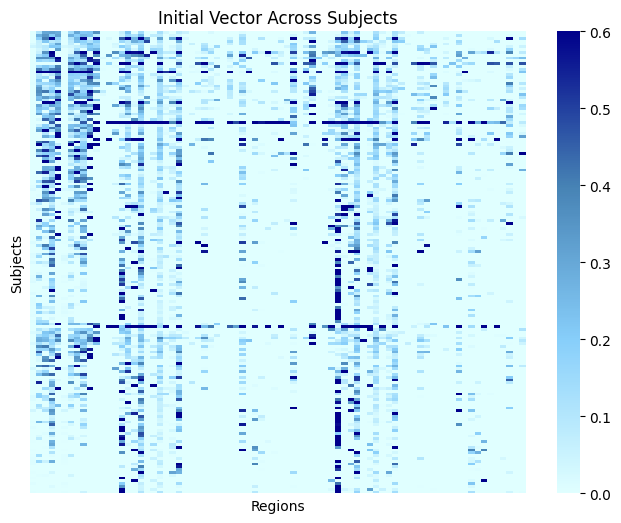

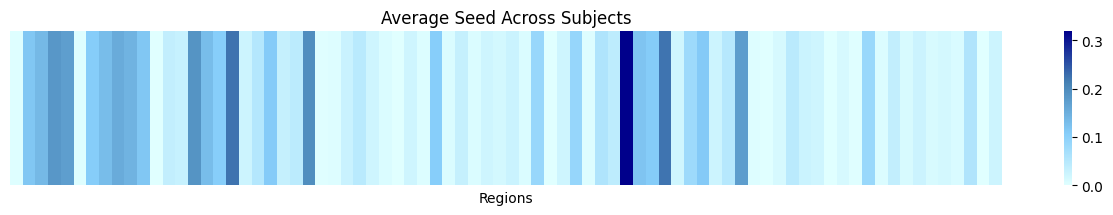

In [454]:
blue_cmap = LinearSegmentedColormap.from_list("custom_blue", ["#E0FFFF", "#87CEFA", "#4682B4", "#00008B"])

# Plot heat map of seeds across subjects
plt.figure(figsize=(8, 6)) 
sns.heatmap(seeding_by_diagnosis.iloc[:,6:], cmap=blue_cmap, xticklabels=False, yticklabels=False, vmax = 0.6)
plt.xlabel('Regions')
plt.ylabel('Subjects')
plt.title('Initial Vector Across Subjects')

# Plot average seed 
plt.figure(figsize=(16, 2)) 
sns.heatmap(means_seed.iloc[:, 5:], cmap=blue_cmap, xticklabels=False, yticklabels=False)
plt.xlabel('Regions')
plt.title('Average Seed Across Subjects')

#Sort regions by highest averages and print
sorted_regions = means_seed.iloc[:, 6:].sort_values(by=0, axis=1, ascending=False)
sorted_regions = sorted_regions.columns.tolist()
print('Regions with highest average tau seed density: ' + str(sorted_regions))
sorted_regions_MCI = means_seed_MCI.iloc[:, 6:].sort_values(by=0, axis=1, ascending=False)
sorted_regions_MCI = sorted_regions_MCI.columns.tolist()
print('Regions with highest average seed MCI: ' + str(sorted_regions_MCI))
sorted_regions_AD = means_seed_AD.iloc[:, 6:].sort_values(by=0, axis=1, ascending=False)
sorted_regions_AD = sorted_regions_AD.columns.tolist()
print('Regions with highest average seed AD: ' + str(sorted_regions_AD))


In [435]:
# Save average optimized seed for Pysurfer plotting
average_seed = means_seed.iloc[:, 5:]
average_seed.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Pysurfer data/Average individually optimized seed - version 11.csv')

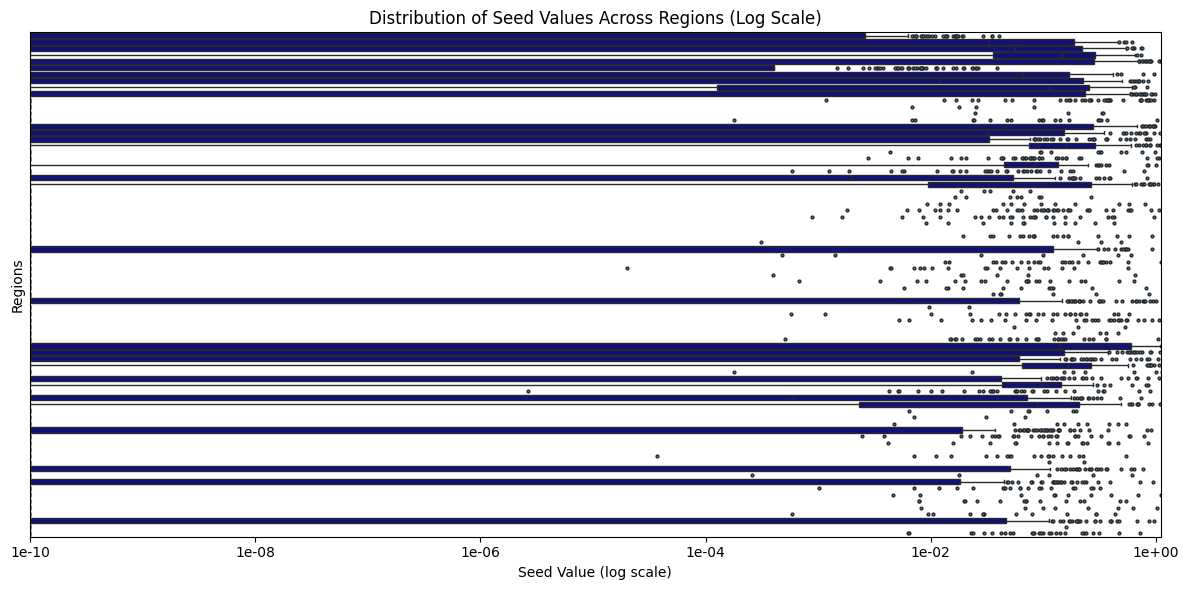

In [455]:
# Box plot of optimized seeds across regions

data_melted = seeding_nonzero.iloc[:, 6:].melt(var_name='Region', value_name='Seed Value')

data_melted['Seed Value'] = data_melted['Seed Value'].replace(0, 1e-10)

flierprops = dict(marker='o', markersize=2, linestyle='none', markerfacecolor='#4682B4')

plt.figure(figsize=(12, 6))
sns.boxplot(y='Region', x='Seed Value', data=data_melted, color='#00008B', showfliers=True, flierprops=flierprops)

plt.yticks([])
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('Seed Value (log scale)')
plt.ylabel('Regions')
plt.title('Distribution of Seed Values Across Regions (Log Scale)')
plt.xlim(1e-10, 1.1)  
plt.minorticks_on()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0e}'))

plt.tight_layout()
plt.show()

(0.0, 165.0)

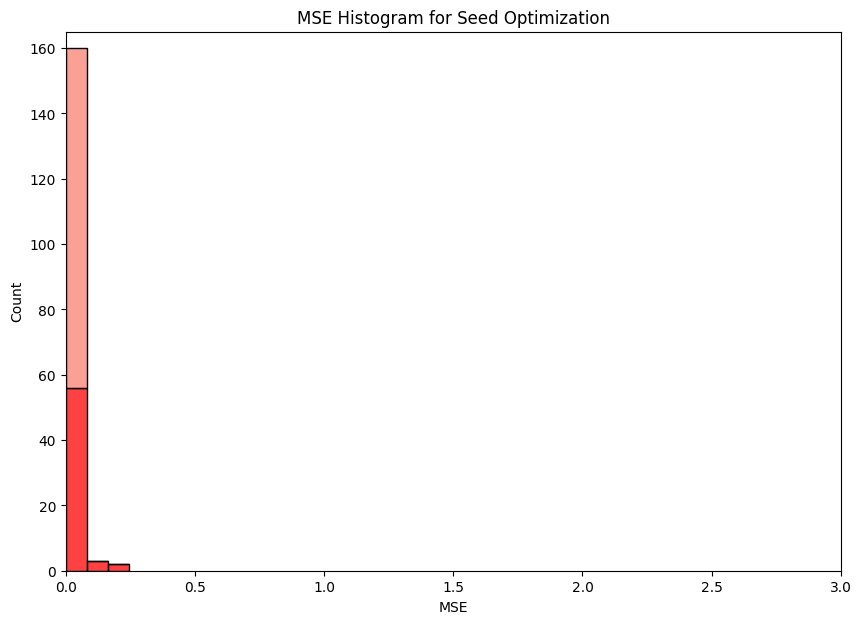

In [456]:
# Create histogram of MSE 
plt.figure(figsize=(10, 7))
ax = sns.histplot(data=seeding_nonzero, binwidth = 0.09, x='MSE', color = 'red', hue='Diagnosis', palette=color_palette, multiple='stack',legend=False)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.title('MSE Histogram for Seed Optimization')
plt.xlim(0, 3)
plt.ylim(0, 165)


(0.0, 55.0)

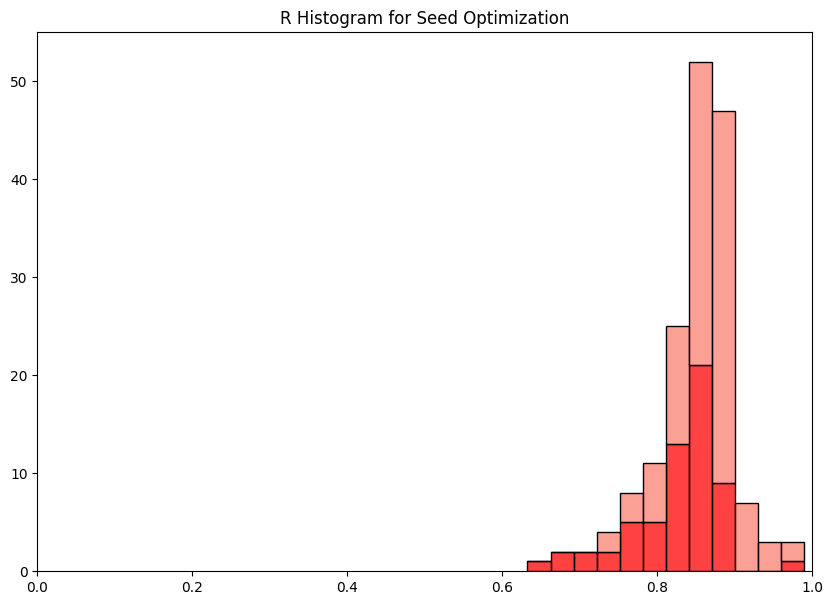

In [457]:
# Histogram of R 
plt.figure(figsize=(10, 7)) 
ax = sns.histplot(data=seeding_nonzero, binwidth= 0.03, x='R', color = 'red', hue='Diagnosis', palette=color_palette, multiple='stack',legend=False)
plt.xlabel('')
plt.ylabel('')
plt.title('R Histogram for Seed Optimization')
plt.xlim(0, 1)
plt.ylim(0, 55)

## Means and Variance

In [458]:
# Define mean MSE and Pearson's R for param op
print("Parameter Optimization:")

# Overall
mean_mse_param = means_param['MSE'].iloc[0]
print('Mean MSE Overall: ' + str(mean_mse_param))
mean_R_param = means_param['R'].iloc[0]
print('Mean R Overall: ' + str(mean_R_param))

# By diagnostic category 
mean_mse_param_CN = means_param_CN['MSE'].iloc[0]
print('Mean MSE CN: ' + str(mean_mse_param_CN))
mean_R_param_CN = means_param_CN['R'].iloc[0]
print('Mean R CN: ' + str(mean_R_param_CN))
mean_mse_param_MCI = means_param_MCI['MSE'].iloc[0]
print('Mean MSE MCI: ' + str(mean_mse_param_MCI))
mean_R_param_MCI = means_param_MCI['R'].iloc[0]
print('Mean R MCI: ' + str(mean_R_param_MCI))
mean_mse_param_AD = means_param_AD['MSE'].iloc[0]
print('Mean MSE AD: ' + str(mean_mse_param_AD))
mean_R_param_AD = means_param_AD['R'].iloc[0]
print('Mean R AD: ' + str(mean_R_param_AD))

print("     ")

# Define mean MSE and Pearson's R for seed op
print("Seed Optimization:")

# Overall
mean_mse_seed = means_seed['MSE'].iloc[0]
print('Mean MSE Overall: ' + str(mean_mse_seed))
mean_R_seed = means_seed['R'].iloc[0]
print('Mean R Overall: ' + str(mean_R_seed))

# By diagnostic category 
mean_mse_seed_CN = means_seed_CN['MSE'].iloc[0]
print('Mean MSE CN: ' + str(mean_mse_seed_CN))
mean_R_seed_CN = means_seed_CN['R'].iloc[0]
print('Mean R CN: ' + str(mean_R_seed_CN))
mean_mse_seed_MCI = means_seed_MCI['MSE'].iloc[0]
print('Mean MSE MCI: ' + str(mean_mse_seed_MCI))
mean_R_seed_MCI = means_seed_MCI['R'].iloc[0]
print('Mean R MCI: ' + str(mean_R_seed_MCI))
mean_mse_seed_AD = means_seed_AD['MSE'].iloc[0]
print('Mean MSE AD: ' + str(mean_mse_seed_AD))
mean_R_seed_AD = means_seed_AD['R'].iloc[0]
print('Mean R AD: ' + str(mean_R_seed_AD))

Parameter Optimization:
Mean MSE Overall: 0.699571545433896
Mean R Overall: 0.14964672689781044
Mean MSE CN: nan
Mean R CN: nan
Mean MSE MCI: 0.46449805143432576
Mean R MCI: 0.15762639419433264
Mean MSE AD: 1.1003525843839825
Mean R AD: 0.13604204822832994
     
Seed Optimization:
Mean MSE Overall: 0.018238731724113975
Mean R Overall: 0.8491542224930017
Mean MSE CN: nan
Mean R CN: nan
Mean MSE MCI: 0.012290260192804726
Mean R MCI: 0.8636197071727307
Mean MSE AD: 0.02838038810536253
Mean R AD: 0.8244917568095296


## Covariance Matrices, Variance, and SVDs

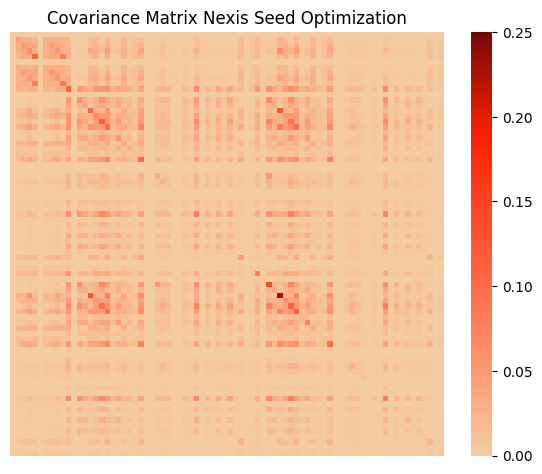

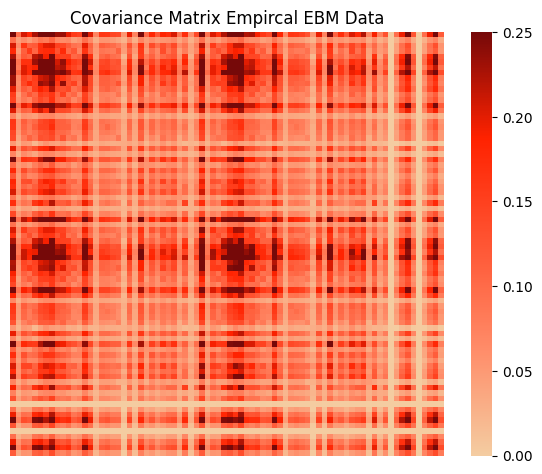

In [108]:
# Color map
orange_cmap =LinearSegmentedColormap.from_list("yellow", ["#f4cca1", "#ff8c69","#ff5533", "#ff2200", "#760909"])

# Convert relevant columns to numeric, coercing errors to NaN
seeding_nonzero.iloc[:, 8:] = seeding_nonzero.iloc[:, 8:].apply(pandas.to_numeric, errors='coerce')
ebm_nonzero.iloc[:, 4:] = ebm_nonzero.iloc[:, 4:].apply(pandas.to_numeric, errors='coerce')

# Check for NaN values and handle them 
seeding_nonzero = seeding_nonzero.dropna(subset=seeding_nonzero.columns[8:], how='any')
ebm_nonzero = ebm_nonzero.dropna(subset=ebm_nonzero.columns[4:], how='any')

# Initialize the sum matrices
n = len(seeding_nonzero) # Number of subjects
Sum_seed = np.zeros((78, 78))
Sum_ebm = np.zeros((78, 78))

# Loop through all subjects
for i in range(len(seeding_nonzero)):
    x0_i = seeding_nonzero.iloc[i, 8:].values.astype(np.float64) 
    M_i = np.outer(x0_i, x0_i)
    Sum_seed += M_i

    x_i = ebm_nonzero.iloc[i, 4:].values.astype(np.float64)  
    M_i_ebm = np.outer(x_i, x_i)
    Sum_ebm += M_i_ebm

# Compute the average
E_model = Sum_seed / n
E_ebm= Sum_ebm / n

plt.figure(figsize=(7, 5.5)) 
sns.heatmap(E_model, cmap=orange_cmap, vmin=0, xticklabels=False, yticklabels=False, vmax = 0.25)
plt.title('Covariance Matrix Nexis Seed Optimization')

plt.figure(figsize=(7, 5.5)) 
sns.heatmap(E_ebm, cmap=orange_cmap, vmin=0, xticklabels=False, yticklabels=False, vmax = 0.25)
plt.title('Covariance Matrix Empircal EBM Data')

# Take the diagonal of both plot on PySurfer
Variance_model = np.diag(E_model)
Variance_ebm= np.diag(E_ebm)

# SVD and EVD for E_model matrix
U_model, S_model, VT_model = np.linalg.svd(E_model)
eigenvalues_model, eigenvectors_model = np.linalg.eig(E_model)

# SVD and EVD for E_ebm matrix
U_ebm, S_ebm, VT_ebm = np.linalg.svd(E_ebm)
eigenvalues_ebm, eigenvectors_ebm = np.linalg.eig(E_ebm)

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_37329/3606015947.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_seed_df = pandas.concat([variance_seed_df, sub_seed_df], ignore_index=True)
/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_37329/3606015947.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_empirical_df = pandas.concat([variance_empirical_df, sub_empirical_df], ignore_index=True)


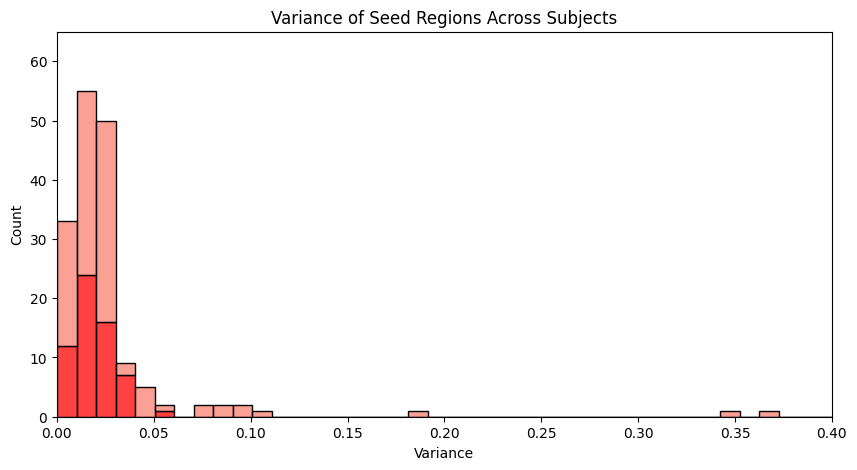

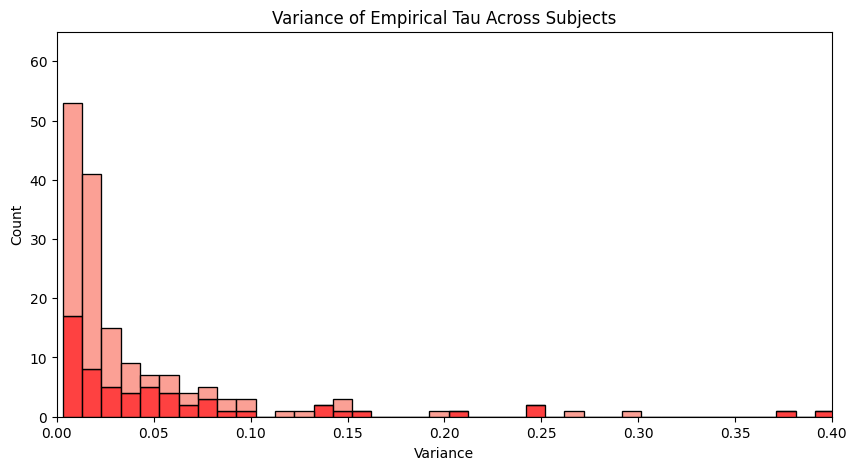

In [109]:
# Plot variance of regional tau for each subject

column_names = ['RID', 'Diagnosis', 'Variance']
variance_seed_df = pandas.DataFrame(columns=column_names)
variance_empirical_df = pandas.DataFrame(columns=column_names)

# Calculate variance
for i in range(len(seeding_nonzero)):
    seed_tau = seeding_nonzero.iloc[i, 6:]
    empirical_tau = ebm_nonzero.iloc[i, 4:]
    variance_seed = seed_tau.var()
    variance_empirical = empirical_tau.var()
    
    sub_seed_df = pandas.DataFrame([[seeding_nonzero.iloc[i, 1], seeding_nonzero.iloc[i, 2], variance_seed]], 
                                columns=column_names)
    variance_seed_df = pandas.concat([variance_seed_df, sub_seed_df], ignore_index=True)
    
    sub_empirical_df = pandas.DataFrame([[ebm_nonzero.iloc[i, 1], ebm_nonzero.iloc[i, 2], variance_empirical]], 
                                     columns=column_names)
    variance_empirical_df = pandas.concat([variance_empirical_df, sub_empirical_df], ignore_index=True)
    
# Plotting
plt.figure(figsize=(10, 5))
ax = sns.histplot(data=variance_seed_df, x='Variance', hue='Diagnosis', binwidth=0.01, 
                  multiple='stack', palette=color_palette, legend=False)
plt.xlabel('Variance')
plt.ylabel('Count')
plt.title('Variance of Seed Regions Across Subjects')
plt.xlim(0, 0.4)
plt.ylim(0, 65)
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.histplot(data=variance_empirical_df, x='Variance', hue='Diagnosis', binwidth=0.01, 
                  multiple='stack', palette=color_palette, legend=False)
plt.xlabel('Variance')
plt.ylabel('Count')
plt.title('Variance of Empirical Tau Across Subjects')
plt.xlim(0, 0.4)
plt.ylim(0, 65)
plt.show()

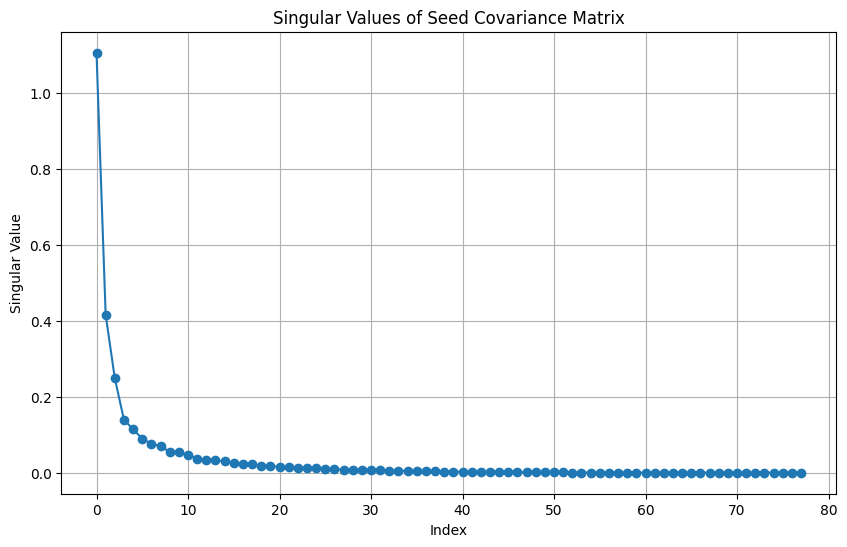

In [110]:
# Plot the singular values of E_model
plt.figure(figsize=(10, 6))
plt.plot(S_model, marker='o', linestyle='-')
plt.title('Singular Values of Seed Covariance Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

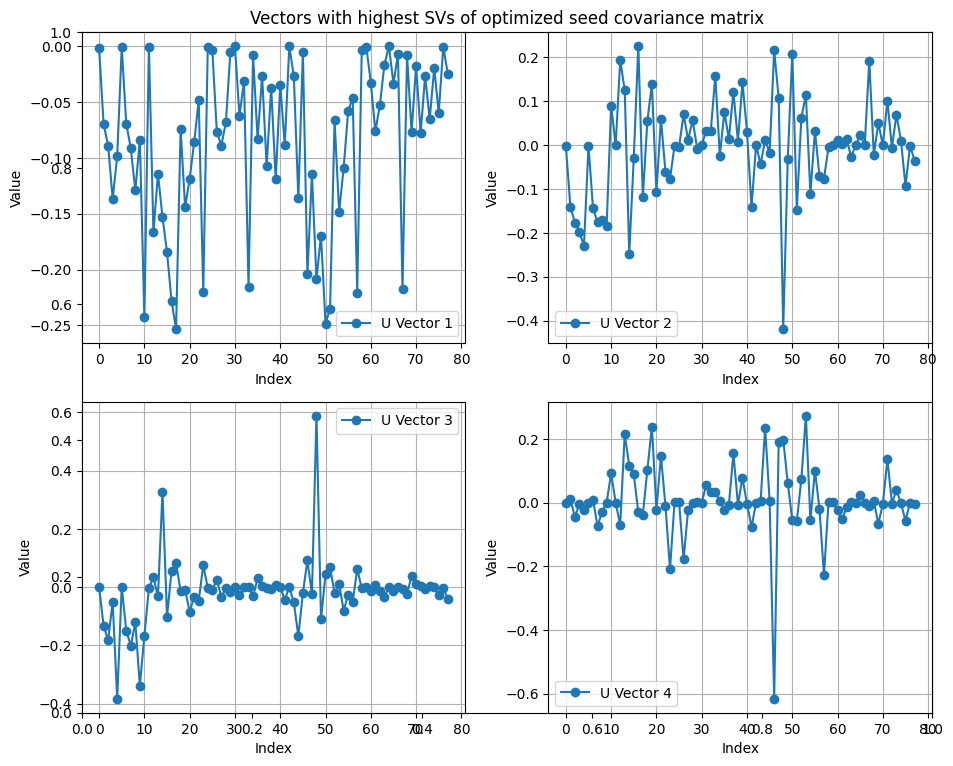

In [111]:
sorted_indices = np.argsort(S_model)[::-1]
sorted_singular_values = S_model[sorted_indices]
sorted_U = U_model[:, sorted_indices]

# Select top 4 vectors SVs and corresponding vectors
top_U_vectors = sorted_U[:, :4]
top_SV = sorted_singular_values[:4]

# Plot the top 4 vectors in U
plt.figure(figsize=(10, 8))
plt.title('Vectors with highest SVs of optimized seed covariance matrix')
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(top_U_vectors[:, i], marker='o', linestyle='-', label=f'U Vector {i+1}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [477]:
# Save to csv to visualize with PySurfer

column_names = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate',	'ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal',	'ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus','ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']
Variance_model_df = pandas.DataFrame(columns=column_names)
Variance_model_df = pandas.concat([Variance_model_df, pandas.DataFrame([Variance_model], columns=column_names)], ignore_index=True)
Variance_model_df.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Pysurfer data/Model Seed Op Variance - version 11.csv')

Variance_ebm_df = pandas.DataFrame(columns=column_names)
Variance_ebm_df = pandas.concat([Variance_ebm_df, pandas.DataFrame([Variance_ebm], columns=column_names)], ignore_index=True)
Variance_ebm_df.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/Pysurfer data/EBM Variance - version 11.csv')

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_1347/898808222.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Variance_model_df = pandas.concat([Variance_model_df, pandas.DataFrame([Variance_model], columns=column_names)], ignore_index=True)
/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_1347/898808222.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Variance_ebm_df = pandas.concat([Variance_ebm_df, pandas.DataFrame([Variance_ebm], columns=column_names)], ignore_i

In [569]:
# FOR NEXIS + DEEP LEARNING PROJECT: Run covariance matrices, variance, and SVD on individuals

cog_data = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/data/ADNI3/Regional_Tau_w_Demographics.csv')
cog_data = cog_data.drop_duplicates(subset='RID', keep='first')
value_to_drop = [4513, 6038, 6505, 6598, 6601, 6509]  
cog_data = cog_data[~cog_data['RID'].isin(value_to_drop)]
cog_data = cog_data[['RID', 'ADAS11_bl']]
DL_df = pandas.merge(cog_data, ebm_nonzero, on='RID', how='inner')
DL_df = DL_df.drop(['Unnamed: 0'],axis=1)
DL_df = DL_df[DL_df['Diagnosis'] != 'CN']
DL_df['eta'] = ''

In [570]:
top_SV_matrix = np.diag(top_SV)
RIDs = np.array(DL_df['RID'])

for RID in RIDs:  # Loop through all subject RIDs
    # Extract the seed values
    dl_index = DL_df.index[DL_df['RID'] == RID].tolist()[0]
    x0_row = seeding_nonzero[seeding_nonzero['RID'] == RID].iloc[0] 
    x0_i = x0_row.iloc[6:].values.astype(np.float64)
    x0_i = x0_i.reshape(78, 1)
    
    # Calculate eta_i
    eta_i = np.dot(np.linalg.inv(top_SV_matrix), np.dot(top_U_vectors.T, x0_i))
    
    # Convert eta_i to string
    eta_i_str = np.array2string(eta_i, separator=',')
    
    # Add eta to DL_df
    DL_df.at[dl_index, 'eta'] = eta_i_str

In [572]:
# Save to csv
DL_df.to_csv('EBM + Nexis + Deep Learning: eta values - latest with stage 0.csv')

## Seed vs. Param- op Model Comparison 

In [538]:
# Calculate AIC 

seeding_length = len(seeding_nonzero)
parameters_length = len(parameters_nonzero)

# Use the smaller length to avoid out-of-bounds errors
min_length = min(seeding_length, parameters_length)

# Number of parameters being optimized
k_param = 2 # alpha, beta, gamma
k_seed = 78 # top 6 seeds

# Number of observations
n = len(seeding_nonzero)

# Compute the log-likelihood for both models
log_likelihoods_param = []
log_likelihoods_seed = []
log_likelihoods_ent = []

for i in range(min_length): # for every subject
    subject_param = parameters_nonzero.iloc[i]
    log_likelihood_param = n / 2 * np.log(subject_param['R'] ** 2)
    log_likelihoods_param.append(log_likelihood_param)

    subject_ent = params_inferiortemporal_seed_nonzero.iloc[i]
    log_likelihood_ent = n / 2 * np.log(subject_ent['R'] ** 2)
    log_likelihoods_ent.append(log_likelihood_ent)

    subject_seed = seeding_nonzero.iloc[i]
    log_likelihood_seed = n / 2 * np.log(subject_seed['R'] ** 2)
    log_likelihoods_seed.append(log_likelihood_seed)

# Sum log likelihoods across all subjects for both models
log_likelihoods_param = np.array(log_likelihoods_param)
log_total_param = log_likelihoods_param.sum()

log_likelihoods_ent = np.array(log_likelihoods_ent)
log_total_ent = log_likelihoods_ent.sum()

log_likelihoods_seed = np.array(log_likelihoods_seed)
log_total_seed = log_likelihoods_seed.sum()

# Calculate AIC for both models
AIC_param = -2 * log_total_param + 2 * k_param
AIC_seed = -2 * log_total_seed + 2 * k_seed
AIC_ent = -2 * log_total_ent + 2 * k_param

print('AIC parameter optimization: ' + str(AIC_param))
print('AIC seed optimization: ' + str(AIC_seed))
print('AIC param optimization with canonical seed: ' + str(AIC_ent))

AIC parameter optimization: 123533.90354210846
AIC seed optimization: 9176.74480087712
AIC param optimization with canonical seed: 159303.82709946035


/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_1347/4158759645.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot([1, 2, 3, 4, 5, 6], [param_op_common_seed_R[i], param_op_entorhinal_seed_R[i], param_op_middletemporal_seed_R[i], param_op_fusiform_seed_R[i], param_op_inferiortemporal_seed_R[i], seed_op_R[i]],
/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_1347/4158759645.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([1, 2, 3, 4, 5, 6], [param_op_common_seed_R[i], param_op_entorhinal_seed_R[i], param_op_middletemporal_seed_R[i], param_op_fusiform_seed_R[i], param_op_inferiortemporal_seed_R[i], seed_op_R[i]],


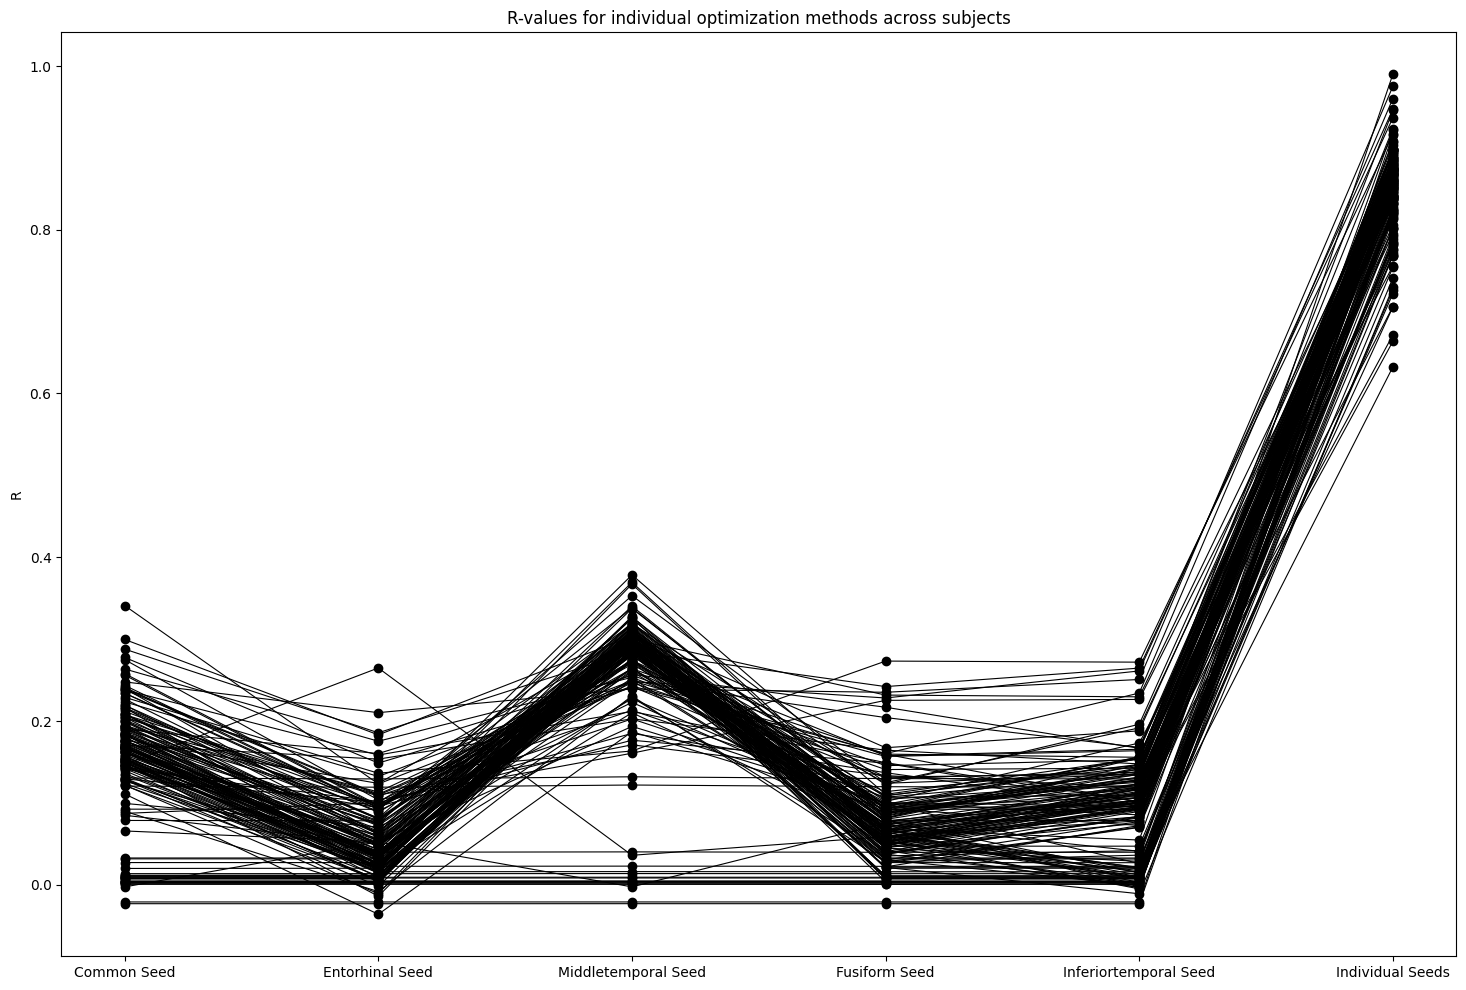

T-statistic Individual Parameters + Common Seed --> Common Parameters + Individual Seeds: -116.67344064705195
P-value: 1.0086381889007526e-159
T-statistic Individual Parameters + Common Seed --> Individual Parameters + Entorhinal Seed: 20.86699978090516
P-value: 5.0678861380776573e-48


In [527]:
# Create a laddergraph and perform paired t-test for seed vs. param op

param_op_common_seed_R = np.array(parameters_nonzero['R'])
param_op_entorhinal_seed_R = np.array(params_entorhinal_seed_nonzero['R'])
param_op_middletemporal_seed_R = np.array(params_middletemporal_seed_nonzero['R'])
param_op_fusiform_seed_R = np.array(params_fusiform_seed_nonzero['R'])
param_op_inferiortemporal_seed_R = np.array(params_inferiortemporal_seed_nonzero['R'])
seed_op_R = np.array(seeding_nonzero['R'])

# Ladder graph
plt.figure(figsize=(18, 12))
for i in range(len(seed_op_R)):
    plt.plot([1, 2, 3, 4, 5, 6], [param_op_common_seed_R[i], param_op_entorhinal_seed_R[i], param_op_middletemporal_seed_R[i], param_op_fusiform_seed_R[i], param_op_inferiortemporal_seed_R[i], seed_op_R[i]], 
             'bo-', 
             color='black',
             linewidth=0.8,    # Line width
             marker='o',       # Marker style
             markersize=6)
plt.xticks([1, 2, 3, 4, 5, 6], ['Common Seed', 'Entorhinal Seed', 'Middletemporal Seed','Fusiform Seed', 'Inferiortemporal Seed', 'Individual Seeds']) 
plt.ylabel('R')
plt.title('R-values for individual optimization methods across subjects')
plt.show()

# Paired t-tests
t_statistic, p_value = stats.ttest_rel(param_op_common_seed_R, seed_op_R)
print(f"T-statistic Individual Parameters + Common Seed --> Common Parameters + Individual Seeds: {t_statistic}")
print(f"P-value: {p_value}")

t_statistic_can, p_value_can = stats.ttest_rel(param_op_common_seed_R, param_op_entorhinal_seed_R)
print(f"T-statistic Individual Parameters + Common Seed --> Individual Parameters + Entorhinal Seed: {t_statistic_can}")
print(f"P-value: {p_value_can}")

In [466]:
# Calculate sparcity of optimized seed across all subjects

def sparsity_calc(seed):
    # seed must be an array
    max_value = np.max(seed)
    threshold = max_value * 0.1
    return np.sum(seed > threshold)  

sparsity_list = []
for i in range(len(seeding_nonzero)):
    seed = seeding_nonzero.iloc[i, 6:]  
    sparsity = sparsity_calc(seed.values)
    sparsity_list.append(sparsity)

sparsity_array = np.array(sparsity_list)
mean_sparsity = np.mean(sparsity_array)
print(f'Average optimized seed sparsity across subjects: {mean_sparsity:.2f}')

def energy_calc(seed): 
    seed = np.array(seed)
    seed_ordered = np.sort(seed)[::-1]
    seed_sum = seed.sum()
    percent_of_sum = seed_sum * 0.9

    temp_sum = 0
    for value in seed_ordered:
        temp_sum = temp_sum + value
        if temp_sum > percent_of_sum:
            threshold = value
            count_sparse_regions = np.sum(seed > threshold)
            return count_sparse_regions

energy_list = []
for i in range(len(seeding_nonzero)):
    seed = seeding_nonzero.iloc[i, 6:]  
    energy = energy_calc(seed.values)
    energy_list.append(energy)

energy_array = np.array(energy_list)
mean_energy = np.mean(energy_array)
print(f'Average number of regions above threshold (regions that contribute to 90% of total seed energy): ' + str(mean_energy))

Average optimized seed sparsity across subjects: 14.32
Average number of regions above threshold (regions that contribute to 90% of total seed energy): 12.012121212121212


## Longitudinal Validation of Model

Average R_longitudinal: 0.8169


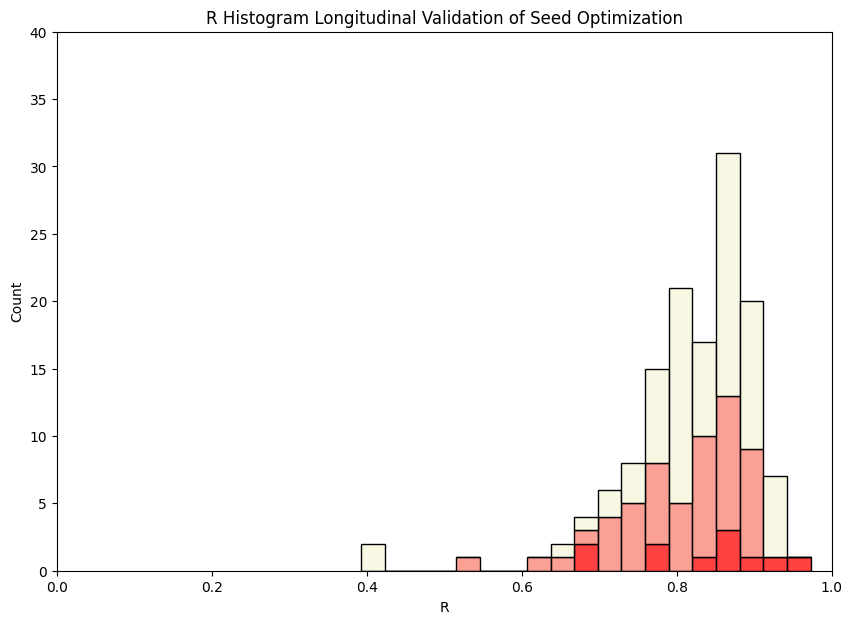

In [99]:
# Histogram of R longitudinal validation 
plt.figure(figsize=(10, 7)) 
ax = sns.histplot(data=seeding_all, binwidth= 0.03, x='R_longitudinal', color = 'red', hue='Diagnosis', palette=color_palette, multiple='stack',legend=False)
plt.xlabel('R')
plt.ylabel('Count')
plt.title('R Histogram Longitudinal Validation of Seed Optimization')
plt.xlim(0, 1)
plt.ylim(0,40)

average_R_longitudinal = seeding_all['R_longitudinal'].mean()
print(f"Average R_longitudinal: {average_R_longitudinal:.4f}")


Average MSE_longitudinal: 0.0135


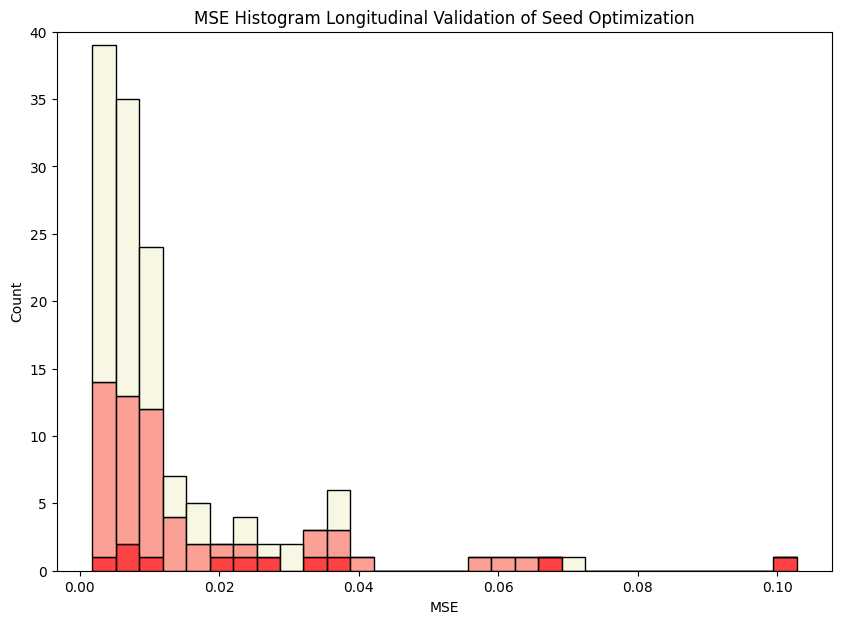

In [100]:
# Histogram of R longitudinal validation 
plt.figure(figsize=(10, 7)) 
ax = sns.histplot(data=seeding_all, x='MSE_longitudinal', color = 'red', hue='Diagnosis', palette=color_palette, multiple='stack',legend=False)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.title('MSE Histogram Longitudinal Validation of Seed Optimization')
plt.ylim(0,40)

average_MSE_longitudinal = seeding_all['MSE_longitudinal'].mean()
print(f"Average MSE_longitudinal: {average_MSE_longitudinal:.4f}")